In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
import time
import re
import random
import os
from os import path
import io
from collections import Counter
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.stem.porter import *
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk import RegexpTagger
from nltk import AffixTagger
from nltk import NgramTagger
from nltk import UnigramTagger
from nltk.corpus import brown
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
from nltk.corpus import brown
nltk.download('brown', quiet=True)
nltk.download('universal_tagset', quiet=True)
from PIL import Image

#Loading Data

In [0]:
df = pd.read_csv("7-NLP-REDDIT-2.csv")

# Describing the Data Set 
The use of Reddit data was decided upon reviewing the subject "domestic violence" and "domestic abuse", where 10.2K users, mainly women share their testomonies of abuse either family abuse or relationship abuse of them or their friends, seeking different subjects as: testimonials, advice, doubts among others. 

We retrieved a sample of the data (821 testimonies) through a scrapping tool, due through the limitations of the scrapping tool (Scrape Storm)

# Pre Processing
Since the column "Title", "Body_1","Body_2" have all the components of the comments, we concatenate them, to have the whole testimonies. 

In [0]:
#concatanate title and content
df['Content'] = df['Title'].map(str) + ' ' + df['Body_1'].map(str) + ' ' +  df['Body_2'].map(str)

In [0]:
# Remove Contractions 
def decontracted(phrase):
    """
    Function uses regular expression to substitute common constructs used in text which 
    involve contractions.
    A contraction is a shortened form of one or two words (one of which is usually a verb).
    e.g. 'won't' will be replaced with 'will not'

    parameters:
    text (str): the text to use
    """ 
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"he\ ’ s", "he is", phrase)
    phrase = re.sub(r"i\ ’ m", "he is", phrase)
   
   

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\'didnt", " did not", phrase)
    return phrase

In [0]:
# Reduce words length to avoid misspelling like "happpppy" will be "happy"

def reduce_lengthening(text):
    """
    Function uses regular expression to correct spelling errors from the text which involve incorrect repeated letters

    parameters:
    text (str): the text to use
    """  
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

In [0]:
# Apply the above pre-proessing functions to the Comment column

df['Content']=df['Content'].apply(reduce_lengthening, 0) 
df['Content']=df['Content'].apply(decontracted, 0)

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
#Setting Stopwords

from nltk.corpus import stopwords
sw = stopwords.words('english')
stw = sw + ['lot','frog','ppl','tldr','time','nan','thing', 'subject', 're', 'edu', 'use','good','really','quite','nice','well','little','need','keep','make','important','take','get','very','course','instructor','example']
ps = PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [0]:
def nlpFunction(df):
    """
    Function to carry out NLP type functions on the Comment text.
    
    the text is split into tokens 
    stopwords are removed
    lemmatization is carried out
      e.g.  am, are,is  => be
            car, cars, car's, cars = > car
    the <space> separated words are then added to a new column that will be used for sentiment analysis

    parameters:
    df (dataframe): the dataframe to use, the 'Comment' column is used 
    """ 
    df['com_token'] = df['Content'].str.lower().str.split()
    df['com_remv'] = df['com_token'].apply(lambda x: [y for y in x if y not in stw]) #tokenization
    df["com_lemma"] = df['com_remv'].apply(lambda x : [lemmatizer.lemmatize(y) for y in x]) # lemmatization
    df["com_tok_str"] = df["com_lemma"].apply(', '.join)
    df["com_full"] = df["com_lemma"].apply(' '.join)
    return df

In [12]:
nltk.download('wordnet')
df = nlpFunction(df)
df["Orig_comment"] = df["Content"]
df["Comment"] = df["com_full"]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [13]:
df[['Orig_comment','Comment']].head()

,Orig_comment,Comment
0,COVID-19 RESOURCES FOR ABUSE VICTIMS nan nan,covid-19 resource abuse victim
1,Girl I’m “talking” to has a TPO out on her ex ...,girl i’m “talking” tpo ex messaged me. talking...
2,Coronavirus: How is lockdown affecting domesti...,coronavirus: lockdown affecting domestic viole...
3,Concerned friend.. What can I do? Hoping someo...,concerned friend.. do? hoping someone help she...
4,Is it rare that i am a guy who is abused by my...,rare guy abused mom? often feel pretty alone t...


In [14]:
import string
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="?disaster"
print(remove_punct(example))

disaster


In [0]:
df['Comment']=df['Comment'].apply(lambda x : remove_punct(x))

In [16]:
df['Comment'][2]

'coronavirus lockdown affecting domestic violence  stream'

# POS TAGGING

In [0]:
#Import Libraries that threw errors

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
def pos_tagging(Comment):
    pos_text = nltk.pos_tag(nltk.word_tokenize(Comment))
    return " ".join([t + "_" + pos for t, pos in pos_text])

In [0]:
pos_tagging('This is a sentence')

'This_DT is_VBZ a_DT sentence_NN'

In [0]:
df['pos_tagged_text'] = df.Comment.apply(pos_tagging)

In [0]:
df.pos_tagged_text

0              covid19_NN resource_NN abuse_NN victim_NN
1      girl_NN i_NN ’_VBP m_NN “_NN talking_VBG ”_JJ ...
2      coronavirus_NN lockdown_JJ affecting_VBG domes...
3      concerned_JJ friend_NN do_VBP hoping_VBG someo...
4      rare_JJ guy_NN abused_VBN mom_RB often_RB feel...
                             ...                        
816    does_VBZ too_RB whatever_WDT take_VB u_JJ work...
817    feeling_VBG ex_NN texted_VBD lonely_RB red_JJ ...
818    think_VB start_NN feeling_VBG isolated_VBN phy...
819    over_IN finally_RB took_VBD matter_NN hand_NN ...
820    over_IN finally_RB took_VBD matter_NN hand_NN ...
Name: pos_tagged_text, Length: 821, dtype: object

In [0]:
#Pos Taggin - Nouns
def pos_tagging_only_nouns(Comment):
    import nltk
    pos_text = nltk.pos_tag(nltk.word_tokenize(Comment))
    return " ".join([t + "_" + pos for t, pos in pos_text if pos in ['NN', 'NNP', 'NNPS', 'NNS']])

In [0]:
pos_tagging_only_nouns('This is a abuse')

'abuse_NN'

In [0]:
df['nouns'] = df.Comment.apply(pos_tagging_only_nouns)

In [0]:
df.nouns

0              covid19_NN resource_NN abuse_NN victim_NN
1      girl_NN i_NN m_NN “_NN tpo_NN ex_NN weeks_NNS ...
2                   coronavirus_NN violence_NN stream_NN
3      friend_NN someone_NN help_NN situation_NN frie...
4      guy_NN experience_NN cuz_NN people_NNS woman_N...
                             ...                        
816    work_NN year_NN situation_NN way_NN years_NNS ...
817    ex_NN heart_NN ’_NNP t_NN months_NNS man_NN li...
818    start_NN path_NN feel_NN couple_NN night_NN wa...
819    matter_NN hand_NN year_NN year_NN drain_NN mar...
820    matter_NN hand_NN year_NN year_NN drain_NN mar...
Name: nouns, Length: 821, dtype: object

NER
Information extraction that seeks to locate and classify named entities in text into pre-defined categories.

it can help answering many real-world questions, such as:
Which companies were mentioned in the news article?
Were specified products mentioned in complaints or reviews?
Does the tweet contain the name of a person? Does the tweet contain this person’s location?

In [0]:

from nltk.corpus import conll2000
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk.chunk import ne_chunk
from nltk import pos_tag
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    | 

True

In [0]:
def ner_tagging(Comment):
    pos_text = nltk.pos_tag(nltk.word_tokenize(Comment))
    ne_text  = ne_chunk(pos_text)

    
    ner_text = ""
    for chunk in ne_text:
        if hasattr(chunk, 'label'):
            ner_text=ner_text +"NER_"+chunk.label()+" "
        else:
            ner_text=ner_text+str(chunk[0])+" "
    return ner_text

In [0]:
ner_tagging("President Trump Australia said that the crisis was over, according to the Wall Street Journal")

'President NER_PERSON said that the crisis was over , according to the NER_FACILITY '

In [0]:
ner_tagging("aid pay legal fee tldr anyone know aid program help pay back legal fee accrued due domestic violence advicedirection would greatly appreciated ex convited judge trial maryland assulting stalking me appealed violated order landing court five time seven months paid lawyer 200 represent me my ex conviction upheld entire time")

'aid pay legal fee tldr anyone know aid program help pay back legal fee accrued due domestic violence advicedirection would greatly appreciated ex convited judge trial maryland assulting stalking me appealed violated order landing court five time seven months paid lawyer 200 represent me my ex conviction upheld entire time '

In [0]:
df['Comment'][200]

'think domestic violence  i’m 16f boyfriend 17m got licence recently picked took house life town mum  dad lot property anyway room house annoying trying convince thing wasn’t comfortable kept saying no wouldn’t stop asking said wanted go home said wouldn’t drive home atleast tried wanted ‘see liked it’  asking blow him'

In [0]:
df['NER'] = df.Comment.apply(ner_tagging)

# Topic Modeling

In [17]:
pip install pyldavis

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 46.2MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=54a3083ddbfd88575e6aca3cc95099edfdbcd46b52a96e861aa482084773aeaa
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=4aa40981ee4b7e7c3b38bd94d65bc9fa92614914b6a15dcb6454b4b09661966f
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyldavis funcy


In [0]:
try:
    import re2 as re
except ImportError:
    import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
%matplotlib inline

In [0]:
import re
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [0]:
df['Comment']=df['Comment'].apply(lambda x : remove_URL(x))

In [21]:
# Convert to list
data = df['Comment'].values.tolist()
pprint(data[:20])

['covid19 resource abuse victim',
 'girl i’m “talking” tpo ex messaged me talking girl fairly frequently last 3 '
 'weeks first week talking supposed come hang stopped responding me turn ex '
 'boyfriend stopped apartment beat her arrested got temporary protection order '
 'him since violated protection order warrant arrest',
 'coronavirus lockdown affecting domestic violence  stream',
 'concerned friend do hoping someone help shed light current situation best '
 'friend 20yr old recently moved abusive boyfriend fought constantly moved '
 'would break multiple thing threaten kill crash car recent express concern '
 'relationship although knew denial tonight called cry barely able form '
 'sentence asked could come ofc welcomed stay night almost hour passed calling '
 'phone unavailable mind racing knew something right hopped car drive place '
 'starting worry thing got hand received message boyfriend friend account '
 'managed hold of told hid bathroom throwing up concerned waited leav

In [22]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['covid', 'resource', 'abuse', 'victim'], ['girl', 'talking', 'tpo', 'ex', 'messaged', 'me', 'talking', 'girl', 'fairly', 'frequently', 'last', 'weeks', 'first', 'week', 'talking', 'supposed', 'come', 'hang', 'stopped', 'responding', 'me', 'turn', 'ex', 'boyfriend', 'stopped', 'apartment', 'beat', 'her', 'arrested', 'got', 'temporary', 'protection', 'order', 'him', 'since', 'violated', 'protection', 'order', 'warrant', 'arrest']]


In [23]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=5) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=3)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[10]]])

['mom_step', 'brother', 'fight', 'help', 'im', 'name', 'damian', 'youngest', 'step_brother', 'step_dad', 'mom', 'mom', 'brother', 'fight', 'got_physical', 'one', 'called_cop', 'recently', 'wednesday', 'cop', 'anything', 'sometimes', 'violent', 'thought', 'hurt', 'step_brother', 'brung', 'depression', 'suicdel', 'stuff', 'anxiety', 'punched', 'wall', 'idk', 'police', 'anything', 'bc', 'year_old', 'making', 'call', 'one', 'dose', 'anything', 'step_dad', 'sits', 'dose', 'anything', 'sit', 'idk', 'sometimes', 'rage', 'fire', 'hyped', 'mostly', 'wall', 'people', 'loud', 'punch', 'wall', 'im', 'pissed', 'shit', 'show', 'idk', 'tried', 'talk', 'everyone', 'gave', 'went', 'therapist', 'got', 'pill', 'help', 'anxiety']


In [0]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stw] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [26]:
 #Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:2])

[['resource'], ['week', 'week', 'turn', 'apartment', 'beat', 'warrant', 'arrest']]


In [27]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
#print('Number of unique words in initital documents:', len(dictionary))

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])

[[(0, 1)], [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2)], [(7, 1)], [(1, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 3), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1)], [(20, 1), (35, 1), (40, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 4), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 2), (72, 1), (73, 1)], [(74, 1), (75, 1), (76, 1), (77, 2)], [(22, 1), (30, 1), (32, 1), (40, 2), (56, 1), (71, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 3), (86, 1), (87, 1), (88, 2), (89, 3), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 2), (99, 2), (100, 1

In [28]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:10]]

[[('resource', 1)],
 [('apartment', 1),
  ('arrest', 1),
  ('beat', 1),
  ('turn', 1),
  ('warrant', 1),
  ('week', 2)],
 [('stream', 1)],
 [('apartment', 1),
  ('account', 1),
  ('bathroom', 1),
  ('bit', 1),
  ('boyfriend', 1),
  ('called_cry', 1),
  ('car', 2),
  ('concern', 1),
  ('crash', 1),
  ('current_situation', 1),
  ('denial', 1),
  ('family', 2),
  ('form', 1),
  ('friend', 3),
  ('hand', 1),
  ('help', 1),
  ('hold', 1),
  ('hotline', 1),
  ('hour', 2),
  ('message', 1),
  ('mind', 1),
  ('night', 1),
  ('occurrence', 1),
  ('phone', 2),
  ('pick', 1),
  ('place', 1),
  ('racing', 1),
  ('relationship', 1),
  ('room', 1),
  ('sentence', 1),
  ('service', 1),
  ('situation', 1),
  ('tonight', 1),
  ('way', 1),
  ('worry', 1)],
 [('friend', 1),
  ('room', 1),
  ('way', 1),
  ('arm', 1),
  ('attitude', 1),
  ('behaviour', 1),
  ('confrontation', 1),
  ('coworker', 1),
  ('cuz', 1),
  ('day', 1),
  ('disagreement', 1),
  ('experience', 1),
  ('game', 1),
  ('guy', 1),
  ('harm

In [0]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [30]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.053*"brother" + 0.018*"survivor" + 0.018*"money" + 0.018*"adult" + '
  '0.014*"reality" + 0.014*"girlfriend" + 0.014*"straw" + 0.014*"decision" + '
  '0.014*"gate" + 0.014*"leverage"'),
 (1,
  '0.054*"husband" + 0.022*"friend" + 0.019*"night" + 0.019*"apartment" + '
  '0.018*"abuser" + 0.015*"start" + 0.015*"household" + 0.013*"bit" + '
  '0.013*"situation" + 0.012*"tonight"'),
 (2,
  '0.036*"friend" + 0.026*"abuse" + 0.023*"help" + 0.021*"year" + '
  '0.020*"family" + 0.017*"way" + 0.017*"couple" + 0.015*"night" + '
  '0.015*"daughter" + 0.015*"work"'),
 (3,
  '0.031*"bed" + 0.028*"alcohol" + 0.026*"room" + 0.024*"head" + 0.021*"baby" '
  '+ 0.016*"start" + 0.014*"heart" + 0.013*"floor" + 0.012*"neck" + '
  '0.012*"time"'),
 (4,
  '0.037*"year" + 0.032*"child" + 0.030*"kid" + 0.028*"mom" + 0.028*"day" + '
  '0.026*"life" + 0.021*"father" + 0.019*"relationship" + 0.019*"parent" + '
  '0.019*"mother"'),
 (5,
  '0.032*"hate" + 0.022*"drug" + 0.020*"other" + 0.018*"memory" + '
 

In [0]:
ldatopics = lda_model.show_topics(formatted=False)

In [32]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.432521462742499

Coherence Score:  0.395295647895377


## Interpretation of the 8 topics:

Through all the comments, mainly women are seeking help, sharing their abuse stories, how they survived and how they want to help other people. 

One of the main insights is that the **most important topic is about family abuse**, not relationship abuse, **mentioning mother, father, relationship and child as well as kid, we make the assimption that this people are not fully grown adults** but young adults or teenagers living woith their families. 

Time is also a concept that is frequent among all topics, **quoting "year", "month", "day"** as important words describing the testimonies. 

Topic describing: 

1. **Family abuse testimony:**
2. **People seeking help for a friend**
3. **Partner Abuse:** Description of abuse caused by Alcohol - describing partner and relationship
4. **How abuse started: Taliking about a third party:** "Friend"
5. **Description of abuse:** Violence, attack and drunkenn abuse: Also related to Partner abuse
6.** Violent abuse: **Describing a trauma that lead to an injury, quoting "hospital" and "death"
7. **Surviving statement:** second word being survivor and describing the people involved: family and relationships, also what stands out is the third word "money" which can be directly related to surviving abuse by having the means on how to move from it as well as therapy. 
8. **Drugs and physical abuse**: Also can be realted to family since there is a mention of "Father". 

## Main Insights:
Organizations and NGO, should have iniciatives and communication through Reddit since it is a space in which people share their testimonies, is a channel where the iniciatives can be communicated to the right people. 

The main insights from the topics is:
1. Family Abuse is the main type. 
2. Friends want to help friends, seeking advice on how to do so 
3. Abuse related to alcohol is related to partner
4. Testimonies about how abuse starting talking in third party can help NGO´s with the communication on start of abuse talking about a friend. 
5. Surviving statements have words related to money and therapy. 

This social media can also be a way of communicating safety for people who are in close proximity with abusers similar to this pandemic. 

In [33]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.263485 -0.000918       1        1  26.737309
2     -0.222802  0.009464       2        1  24.234261
6      0.059498 -0.243684       3        1   9.974943
1      0.015364  0.152848       4        1   9.115277
3      0.148886  0.084311       5        1   8.490917
7      0.098151 -0.076739       6        1   7.803401
0      0.068706 -0.068471       7        1   6.956079
5      0.095682  0.143189       8        1   6.687816, topic_info=             Term        Freq       Total Category  logprob  loglift
258       husband   86.000000   86.000000  Default  30.0000  30.0000
112         child  142.000000  142.000000  Default  29.0000  29.0000
20         friend  185.000000  185.000000  Default  28.0000  28.0000
151       brother   62.000000   62.000000  Default  27.0000  27.0000
58            mom  126.000000  126.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
2850  doneinstead    8.171758   16.248478   Topic8  -4.9162   2.0176
2849  blacked_eye    8.171758   16.248478   Topic8  -4.9162   2.0176
93         person    8.496789   68.632973   Topic8  -4.8772   0.6158
64         reason    8.227773   79.321404   Topic8  -4.9094   0.4389
145        advice    8.176296   68.692673   Topic8  -4.9157   0.5765

[411 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
144       1  0.366429      abuse
144       2  0.536741      abuse
144       3  0.020644      abuse
144       6  0.005161      abuse
144       7  0.067093      abuse
...     ...       ...        ...
73        1  0.652561       year
73        2  0.339957       year
73        7  0.007815       year
171       2  0.517045  yesterday
171       6  0.437500  yesterday

[534 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 7, 2, 4, 8, 1, 6])

In [0]:
pyLDAvis.save_html(vis, 'REDDITLDA.html')

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

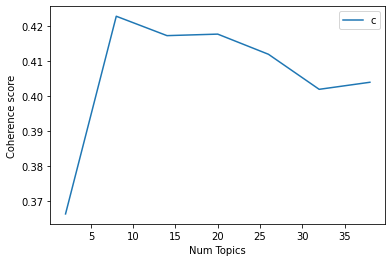

In [0]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [0]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3663
Num Topics = 8  has Coherence Value of 0.4228
Num Topics = 14  has Coherence Value of 0.4173
Num Topics = 20  has Coherence Value of 0.4177
Num Topics = 26  has Coherence Value of 0.412
Num Topics = 32  has Coherence Value of 0.4019
Num Topics = 38  has Coherence Value of 0.404


In [0]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))

[(0,
  '0.020*"mom" + 0.017*"relationship" + 0.010*"people" + 0.010*"mother" + '
  '0.010*"help" + 0.009*"work" + 0.009*"today" + 0.009*"month" + '
  '0.007*"father" + 0.007*"brother" + 0.007*"sister" + 0.007*"room" + '
  '0.007*"family" + 0.006*"week" + 0.006*"phone" + 0.005*"face" + '
  '0.005*"friend" + 0.005*"abuse" + 0.005*"dad" + 0.005*"parent" + 0.005*"day" '
  '+ 0.005*"money" + 0.005*"apartment" + 0.005*"place" + 0.005*"car" + '
  '0.005*"way" + 0.005*"child" + 0.005*"life" + 0.005*"bed" + 0.004*"night"'),
 (1,
  '0.014*"friend" + 0.013*"year" + 0.012*"help" + 0.011*"way" + 0.009*"abuse" '
  '+ 0.008*"relationship" + 0.008*"house" + 0.007*"leave" + 0.007*"car" + '
  '0.007*"month" + 0.007*"boyfriend" + 0.007*"brother" + 0.007*"money" + '
  '0.006*"child" + 0.006*"police" + 0.006*"guy" + 0.005*"week" + '
  '0.005*"control" + 0.005*"room" + 0.005*"family" + 0.005*"talk" + '
  '0.005*"work" + 0.005*"advice" + 0.005*"ex" + 0.005*"abuser" + '
  '0.005*"situation" + 0.004*"people" +

#Dominant topic in each sentence/testimony/document

In [0]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show

pd.set_option('display.max_colwidth', -1)
df_dominant_topic.head(10).sort_values('Topic_Perc_Contrib',ascending=False)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
6,6,0.0,0.9809,"family, friend, relationship, way, parent, mom, year, people, situation, day",lost help okay going try much sense possible two year ago left kid dad abusive towards them took kid left stayed homeless shelter six month program homeless shelter got place yearandahalf ago since met somebody else luck abusive to much physically mentally emotionally like threatening suicide threatening lose kids top hoping stimulus check away decided self income way file tax cuz thought tax filer going guess something wrong know say still processing tax return mean eligible stimulus know wait letter irs try call live person talk to top nobody talk family friends wish phone somebody irs see fix return money away 8 year old boy 7 year old girl 5 year old boy 3 year old girl want girl grow thinking okay man treat way seen treated want boy grow thinking okay treat woman like anybody income child support cash assistance government nothing
3,3,0.0,0.9791,"family, friend, relationship, way, parent, mom, year, people, situation, day",concerned friend do hoping someone help shed light current situation best friend 20yr old recently moved abusive boyfriend fought constantly moved would break multiple thing threaten kill crash car recent express concern relationship although knew denial tonight called cry barely able form sentence asked could come ofc welcomed stay night almost hour passed calling phone unavailable mind racing knew something right hopped car drive place starting worry thing got hand received message boyfriend friend account managed hold of told hid bathroom throwing up concerned waited leaving without see her asked pick broken phone thrown balcony multiple friend blindly ignored violent situation unfolded apartment found way talked car broke told threatened stab family left broke him sat talked 2 hour begged come home would scared hurting family her also consumed xanax smoked weed which regular occurrence returned back room degraded forced sexually told want leave scared confused researching service hotlines help help need still feel bit helpless
4,4,0.0,0.9786,"family, friend, relationship, way, parent, mom, year, people, situation, day",rare guy abused mom often feel pretty alone talking experience cuz seems people victim behaviour woman male partner parents grew mom emotional problems mom would often violently beat stick hanger shoe miss behaved leaving bruised leg arm back would hateful way felt like man would suffered much greater physical harm hold back one 11 mom chased house kitchen knife year always apologize making mad always say reason beat cuz bad oftentimes excuse like you remember beat yell come remember bought expensive toy video game took travel le physical violence simply small disagreement would lash violent manner would rage several day hide room avoid confrontation know always twist around sound like victim woman older feel like people believe me shared friend coworkers expressed supportive attitude feel like still word her
8,8,0.0,0.9416,"family, friend, relationship, way, parent, mom, year, people, situation, day",truly free hi guys never posted finding this felt to know purpose post guess want finally much chest maybe ask question people always made out etc want super long context describe happened me 19 met him 20 met online definitely naive came dating lived pretty big distance away way spoke immediately caught attention absolutely obsessed dated before would never felt drawn someone realise like things intensity made feel typical particularly healthy
1,1,1.0,0.8905,"year, life, relationship, mother, family, people, day, wife, friend, person",girl i’m “talking” tpo ex messaged me talking girl fairly frequently last 3 weeks first week talking supposed come hang stopped responding me turn ex boyfriend stopped apartment beat her arrested got temporary protection order him since violated protection order warrant arrest
5,5,0.0,0.8540,"family, fri

#Most representattive documeny for each topic 

In [0]:
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', -1)
sent_topics_sorteddf_mallet.head().sort_values('Topic_Perc_Contrib',ascending=False)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9920,"family, friend, relationship, way, parent, mom, year, people, situation, day",18 year old sister leave abusive boyfriend long story help trying convince sister leave relationship started dating boy 18 wasn’t originally community mutual friendship family our community close everyone basically connected related someway initially knew cousin 1 worked with always hung etc basically thing kind broke told ice meth didn’t even know guy like oh sucks plus ice common community found dating cousin 2 close friendship sister drug user well that’s learned abusive came told people this started dating sister could imagine reaction this started major conflict cousin 2 online bullying post sloppy second asking would want crack head woman basher etc etc eventually foundation mistrust sister thinking would go back cousin 2 week went sister basically moved caravan parked behind family house looked him lost weight due heavy drug party drug mostly money even though worked full time didn’t pay rent bills groceries basically she’s going hill found posted private instagram concern becoming abusive towards she stated scruffed paranoid texting blanket dismissed “i guess wasn’t fault head” btw pill caravan lay around became suspicious fact might tried ice my sister easily influenced major especially fact eldest sister heavy drug user eg ice heroin 2 year prior attempted murder mother school angered massive slap face mum world ice impacting life again turned 18 put party road hall basically drug fest high ketamine kissed another boy yes boyfriend party fight kicked caravan sister told older cousin work scruffed her also contacted family staying caravan told smoking crack caravan amd told keep pipe back home raised suspicion more also behaviour jacked she memory conversation acted paranoia also hanging around community member known harbouring dealing ice didn’t want massive fight break working cousin 3 speak they close tell everything sister would deny deny deny even turned cousin 3 insinuating crack tried convince boyfriend quit long ago could see right also knew ice year prior also best friend 3 guy knew high school convicted user traffickers sister used accusation mocking way shocking anyone didn’t know inside scoop would also like would never crack wtf lies anyway older male cousin furious threatened boyfriend also knew abusive cousin 2 sister pleaded lying turned them told cousin broke deflate situation also told brother next day shut out made mum turn well complained everyone chiming forgot one told people cousin drove passed house saw car driveway screamed something sister cut fully
4,4.0,0.9875,"mom, relationship, home, help, kid, sister, house, car, head, mother",ohio concerned think neighbor victim dv hi all popped onto subreddit sure post allowed please direct best place them think neighbor may victim dv sometimes hear banging walls tonight contributed sex kid playing around i believe 3 appear like 3 5 7 tonight significantly worse usually last 510 min tonight went upwards half hour hear screaming anything repetitive banging still attributed bed kids right end end what presume be argument heard gutwrenching no scream woman lasted upwards 10 seconds scared shit me wondered contact police perform wellness check sure best do live apartment 3 apartment longways instead side side top other imagine like 150x30 rectangle divide thirds live middle section live end neighbour would able hear them googled i think neighbour abused said sometimes best call police could situation worse kids dad said something arguing street couple week ago getting car leave somewhere like full screaming embarrassing mess introduced kid moved sitting porch came check house late 20 seems like pretty girl never formally met boyfriendhusband seen since moved may got cable installed cable guy hang wire house rap around got knocked storm week prior accent super thick believe russian english fine though however seen since day

# Topic distributions across documents

In [0]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(20)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"family, friend, relationship, way, parent, mom, year, people, situation, day",157.0,0.1912
1.0,1.0,"year, life, relationship, mother, family, people, day, wife, friend, person",114.0,0.1389
2.0,6.0,"child, year, help, life, kid, car, family, advice, situation, friend",117.0,0.1425
3.0,0.0,"family, friend, relationship, way, parent, mom, year, people, situation, day",121.0,0.1474
4.0,0.0,"family, friend, relationship, way, parent, mom, year, people, situation, day",78.0,0.0950
5.0,0.0,"family, friend, relationship, way, parent, mom, year, people, situation, day",104.0,0.1267
6.0,0.0,"family, friend, relationship, way, parent, mom, year, people, situation, day",75.0,0.0914
7.0,3.0,"sister, situation, parent, son, phone, abuse, year, room, kid, life",55.0,0.0670
8.0,0.0,"family, friend, relationship, way, parent, mom, year, people, situation, day",NaN,NaN
9.0,3.0,"sister, situation, parent, son, phone, abuse, year, room, kid, life",NaN,NaN


In [0]:
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel

In [0]:
lsimodel = LsiModel(corpus=corpus, num_topics=8, id2word=id2word)

In [0]:
lsimodel.show_topics()

[(0,
  '0.229*"year" + 0.218*"family" + 0.217*"help" + 0.211*"friend" + 0.207*"mom" + 0.202*"life" + 0.179*"abuse" + 0.172*"relationship" + 0.171*"sister" + 0.166*"child"'),
 (1,
  '-0.765*"sister" + -0.304*"cousin" + -0.152*"mom" + -0.148*"family" + 0.147*"friend" + 0.112*"baby" + 0.111*"child" + -0.108*"drug" + -0.104*"ice" + -0.103*"community"'),
 (2,
  '0.521*"friend" + -0.395*"mom" + -0.241*"son" + -0.200*"child" + 0.183*"relationship" + 0.181*"car" + -0.158*"kid" + -0.157*"mother" + -0.145*"year" + 0.140*"boyfriend"'),
 (3,
  '-0.468*"mom" + -0.345*"friend" + 0.308*"son" + -0.186*"mother" + 0.165*"hour" + 0.153*"week" + -0.153*"brother" + 0.140*"sister" + 0.139*"bed" + 0.131*"room"'),
 (4,
  '0.440*"child" + -0.313*"husband" + -0.263*"mom" + 0.240*"year" + -0.207*"room" + -0.200*"work" + -0.172*"day" + -0.171*"bed" + 0.159*"abuse" + 0.142*"family"'),
 (5,
  '0.553*"child" + -0.278*"year" + -0.220*"mom" + 0.194*"husband" + 0.185*"abuse" + -0.176*"hour" + -0.175*"month" + 0.158*"si

In [0]:
hdpmodel = HdpModel(corpus=corpus, id2word=id2word)

In [0]:
hdpmodel.show_topics()

[(0,
  '0.004*advance + 0.003*broom + 0.002*attempt + 0.002*child + 0.002*trap + 0.002*cali + 0.002*harming + 0.002*grieve + 0.002*trying_stay + 0.002*exfil + 0.002*alcoholism + 0.002*firearm + 0.002*musician + 0.002*material + 0.002*outsider + 0.002*shovedhit + 0.002*hate + 0.002*scenario + 0.002*physically_violent + 0.002*part'),
 (1,
  '0.004*vacation + 0.003*asap + 0.002*harasse + 0.002*hit + 0.002*merit + 0.002*life + 0.002*corner + 0.002*backstory + 0.002*batterer + 0.002*decade + 0.002*feel_safe + 0.002*disability + 0.002*uncle + 0.002*awareness + 0.002*trauma + 0.002*felony + 0.002*boundary + 0.002*threaten + 0.002*period + 0.002*violence'),
 (2,
  '0.003*close_family + 0.003*go + 0.002*abuse + 0.002*last_night + 0.002*choice + 0.002*evidence + 0.002*porcelain + 0.002*correlation + 0.002*patch + 0.002*block + 0.002*existent + 0.002*started_beating + 0.002*bf + 0.002*almost_year + 0.002*friend + 0.002*pet + 0.002*disease + 0.002*good + 0.002*price + 0.002*carry'),
 (3,
  '0.003*

In [0]:
hdptopics = hdpmodel.show_topics(formatted=False)

In [0]:
hdptopics

[(0,
  [('advance', 0.003835862776048983),
   ('broom', 0.002602500019988716),
   ('attempt', 0.002259909773377563),
   ('child', 0.002165123170478167),
   ('trap', 0.002040475364549318),
   ('cali', 0.001991579812639183),
   ('harming', 0.00196718481721984),
   ('grieve', 0.001963141801256007),
   ('trying_stay', 0.0019601727398051295),
   ('exfil', 0.0019482400542232311),
   ('alcoholism', 0.001938687283837607),
   ('firearm', 0.0019291165190726963),
   ('musician', 0.001871914669857022),
   ('material', 0.0018506613586965956),
   ('outsider', 0.0018406214939673052),
   ('shovedhit', 0.001809801569799162),
   ('hate', 0.00180700244854098),
   ('scenario', 0.001771942529728524),
   ('physically_violent', 0.0017671698080854838),
   ('part', 0.0017452333106623267)]),
 (1,
  [('vacation', 0.00367728028920621),
   ('asap', 0.0027058059466744744),
   ('harasse', 0.002251408100241307),
   ('hit', 0.002087812303506482),
   ('merit', 0.002020696365371758),
   ('life', 0.001946229076602058),
 

In [0]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

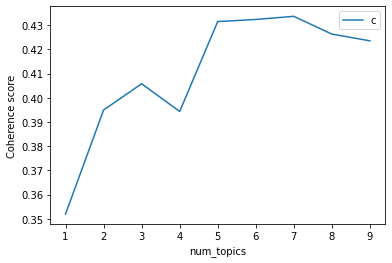

In [0]:
lmlist, c_v = evaluate_graph(dictionary=id2word, corpus=corpus, texts=data_lemmatized, limit=10)

In [0]:
vis2 = pyLDAvis.gensim.prepare(lmlist[3], corpus, id2word)
vis2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.009319 -0.023784  1       1        31.884258
1      0.019392 -0.026007  2       1        25.433651
2     -0.052145  0.005833  3       1        21.706074
0      0.023434  0.043958  4       1        20.976011, topic_info=          Term        Freq       Total Category  logprob  loglift
73   year       198.000000  198.000000  Default  30.0000  30.0000
20   friend     158.000000  158.000000  Default  29.0000  29.0000
167  sister     87.000000   87.000000   Default  28.0000  28.0000
18   family     146.000000  146.000000  Default  27.0000  27.0000
630  door       38.000000   38.000000   Default  26.0000  26.0000
..    ...             ...         ...       ...      ...      ...
161  life       18.318348   140.749725  Topic4  -5.2521  -0.4773 
38   situation  16.816271   100.702408  Topic4  -5.3376  -0.2280 
144  abuse      18.067556   162.731796  Topic4  -5.2659  -0.6362 
92   money      15.632476   78.927505   Topic4  -5.4106  -0.0574 
112  child      16.072443   121.020775  Topic4  -5.3829  -0.4571 

[340 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
144   1      0.448591  abuse 
144   2      0.344125  abuse 
144   3      0.092176  abuse 
144   4      0.110611  abuse 
248   1      0.159732  action
...  ..           ...    ... 
1687  4      0.811562  wound 
73    1      0.206757  year  
73    2      0.479070  year  
73    3      0.206757  year  
73    4      0.110943  year  

[600 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

In [0]:
def ret_top_model():
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    top_topics = [(0, 0)]
    while top_topics[0][1] < 0.97:
        lm = LdaModel(corpus=corpus, id2word=id2word)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=data_lemmatized, dictionary=id2word, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=itemgetter(1), reverse=True)
    return lm, top_topics

In [0]:
from operator import itemgetter

In [0]:
lm, top_topics = ret_top_model()